# Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You're not required to use markdown for your writeup.  If you use another method please just submit a pdf of your writeup.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Camera has distortions, like radial distortion, tangetial distortion, chromatical distortion etc. By comparing the images and original object using cv2 functions, the distortions can be calculated and minimized

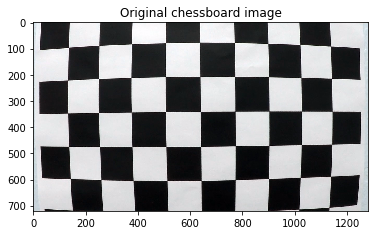

In [67]:
%matplotlib inline
# pick one image to check if 
img = cv2.imread("camera_cal/calibration1.jpg")
plt.imshow(img)
plt.title("Original chessboard image")
plt.show()

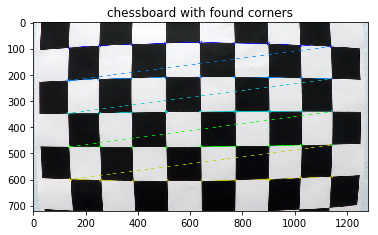

In [7]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# be careful of the 2nd parameter, patternSize=(columns,rows) 
ret, corners = cv2.findChessboardCorners(gray,(9,5),None)

#if found, add object points, image points
if ret == True:
    cv2.drawChessboardCorners(img,(9,5),corners,ret)
    plt.imshow(img)
    plt.title("chessboard with found corners")
    plt.show()

In [8]:
# the above image has 6x 9 corners
nr = 6
nc = 9
# prepare object points, smart idea to use np.mgrid
objp = np.zeros((nr*nc,3),np.float32)
objp[:,:2] = np.mgrid[:nc,:nr].T.reshape(-1,2)
#print(objp)

In [9]:
# use glob to match file with pattern, here the pattern is file extension '.jpg'
calfiles = glob.glob("camera_cal/*.jpg")
# Arrays to store object pongs and image points from all the images
objpoints = [] #3D points with Z axis always 0, Why?
imgpoints = [] #2D points on image, value in pixels

for file in calfiles:
    img = cv2.imread(file)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # be careful of the 2nd parameter, patternSize=(columns,rows) 
    ret, corners = cv2.findChessboardCorners(gray,(nc,nr),None)
    
    #if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img,(nc,nr),corners,ret)
        #plt.imshow(img)
        #plt.show()
        #print("corners found in file : {}".format(file))
    else:
        print("corners not found in file : {}".format(file))


    

corners not found in file : camera_cal/calibration1.jpg
corners not found in file : camera_cal/calibration4.jpg
corners not found in file : camera_cal/calibration5.jpg


In [10]:
# calibrate camera to get transformation matrix
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[1],img.shape[0]),None,None)

### 2. Apply a distortion correction to raw images.

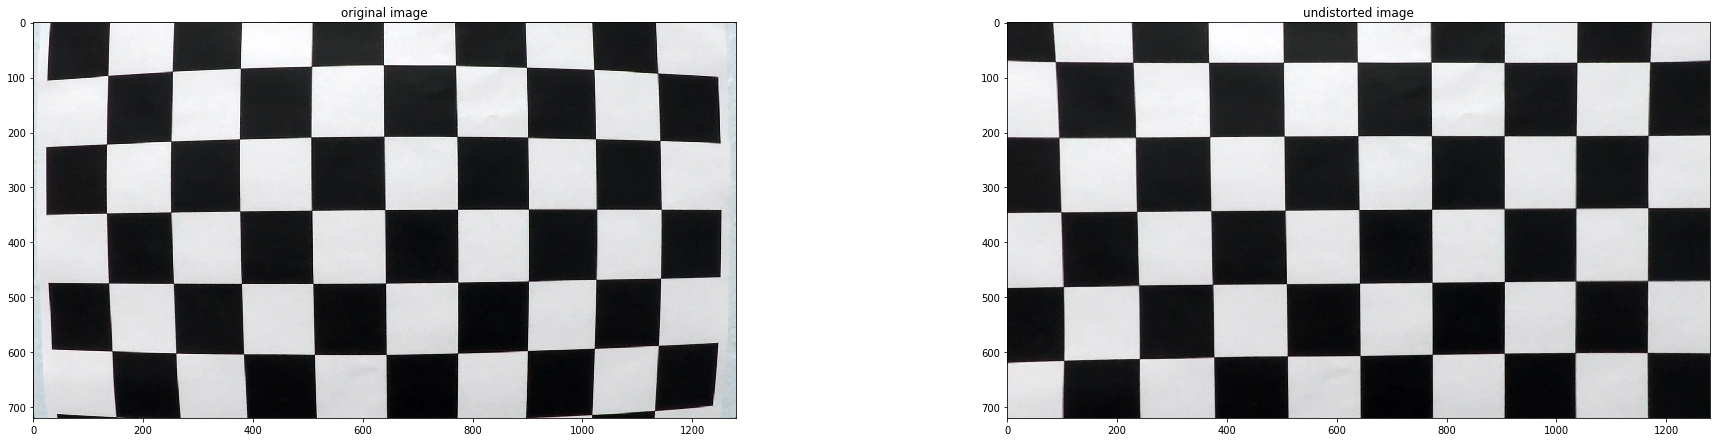

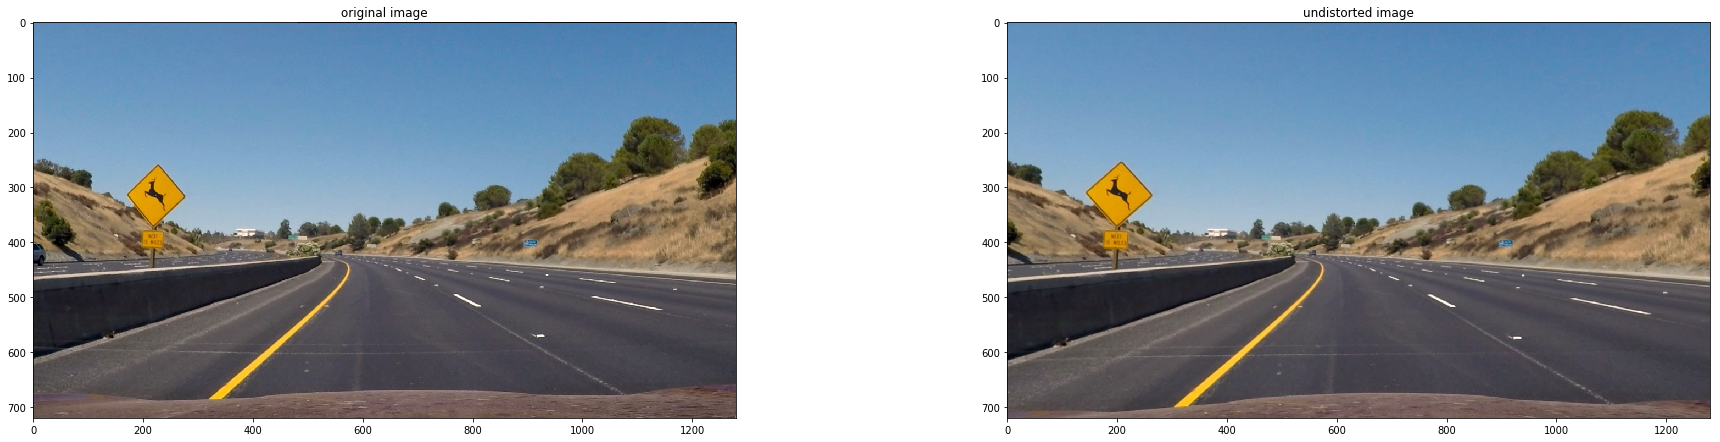

In [15]:
testfiles = glob.glob("test_images/*.jpg")
# check the chessboard image before and after distortion correction
img = cv2.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(img,mtx,dist,None,mtx)

# plog images
fig = plt.figure(figsize=(32,16))
ax =fig.add_subplot(2,2,1)
ax.imshow(img)
ax.set_title("original image")
ax = fig.add_subplot(2,2,2)
ax.imshow(undist)
ax.set_title("undistorted image")

# pick a test image to check before and after distortion correction
img = cv2.imread(testfiles[1])
undist = cv2.undistort(img,mtx,dist,None,mtx)

# plot the images
fig = plt.figure(figsize=(32,16))
ax =fig.add_subplot(2,2,3)
ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax.set_title("original image")
ax = fig.add_subplot(2,2,4)
ax.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
ax.set_title("undistorted image")

plt.show()

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.     

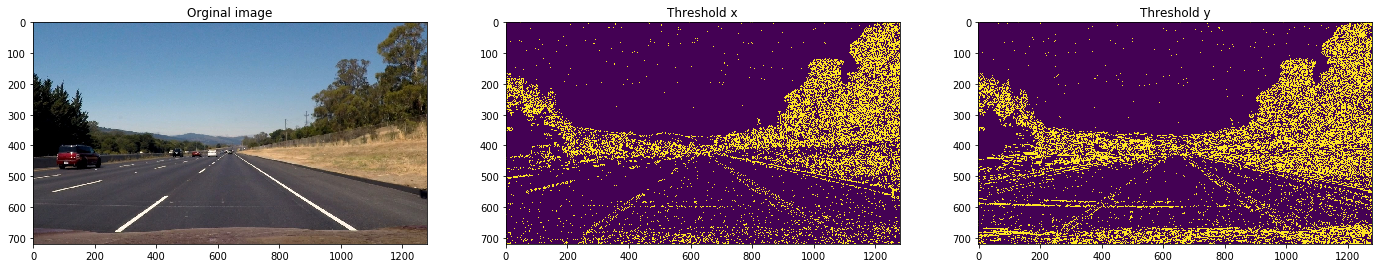

In [16]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def abs_thresh(img,orient='x', sobel_kernel=3,thresh=(0,255)):
    """ apply absolute value thresh hold on a image in x or y direction
    argugments:
    img -- input image
    sobel_kernel -- the sobel kernel size (default 3)
    orient -- orientation, default(x axis)
    thresh -- threshold for low and high magnitude(default 0,255)
    return -- a binary image with gradient within threshold 
    
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    sobel = np.abs(sobel)
    binary_output = np.zeros_like(sobel)
    
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

abs_x = abs_thresh(img, orient='x',sobel_kernel=3,thresh=(20,100))
abs_y = abs_thresh(img, orient='y',sobel_kernel=3,thresh=(20,100))

plt.clf()

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(abs_x)
ax2.set_title("Threshold x")
ax3.imshow(abs_y)
ax3.set_title("Threshold y")
plt.show()
    

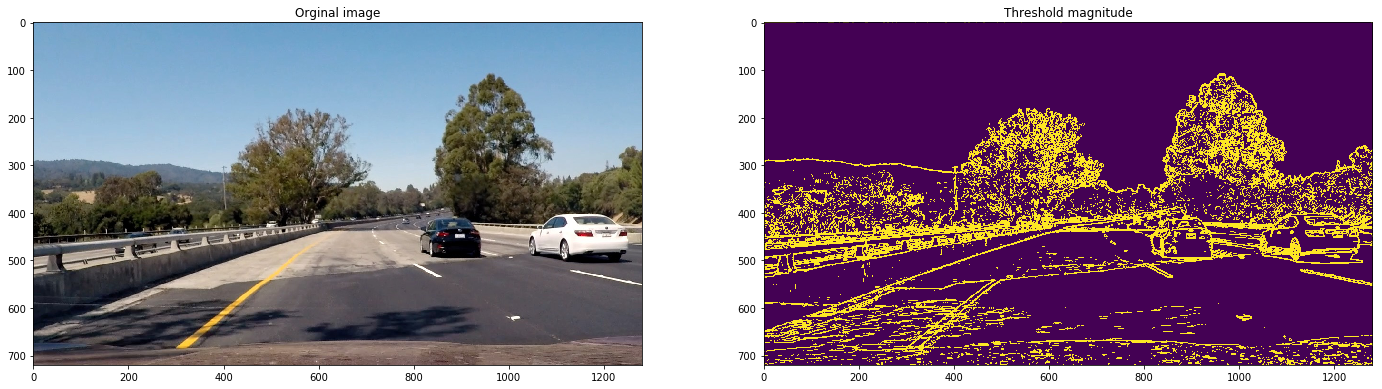

In [106]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def mag_thresh(img,sobel_kernel=3,thresh=(0,255)):
    """ apply magnitude thresh hold on a image
    argugments:
    img -- input image
    sobel_kernel -- the sobel kernel size (default 3)
    thresh -- threshold for low and high magnitude
    return -- a binary image with gradient within threshold 
    
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    sobel= np.sqrt(sobelx**2 + sobely**2)
    sobel_scale = np.uint8(255 * sobel/np.max(sobel))
    binary_output = np.zeros_like(sobel_scale)
    binary_output[(sobel_scale >= thresh[0]) & (sobel_scale <= thresh[1])] = 1
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

mag_img = mag_thresh(img,sobel_kernel=3,thresh=(20,255))

plt.clf()

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(mag_img)
ax2.set_title("Threshold magnitude")

plt.show()
    

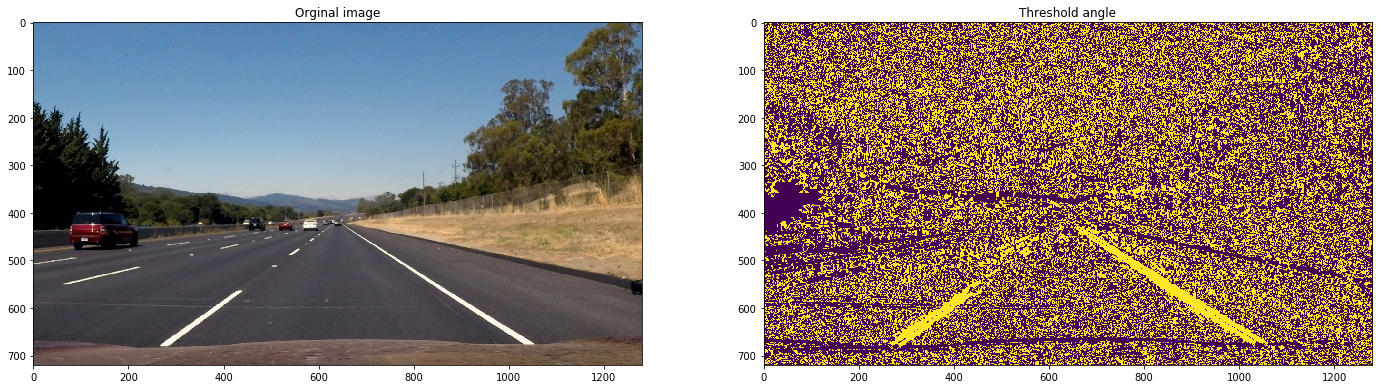

In [107]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def dir_thresh(img,sobel_kernel=3,thresh=(0,np.pi/2)):
    """ apply angle threshold on a image
    argugments:
    img -- input image
    sobel_kernel -- the sobel kernel size (default 3)
    thresh -- threshold for angle to horizon, i.e. horizontal line has angle=0
    return -- a binary image with gradient within angle threshold 
    
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    sobel_angle = np.arctan2(np.abs(sobely),np.abs(sobelx))
    
    binary_output = np.zeros_like(sobel_angle)
    binary_output[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

dir_img = dir_thresh(img,sobel_kernel=15,thresh=(0.7,1.3))

plt.clf()

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(dir_img)
ax2.set_title("Threshold angle")

plt.show()

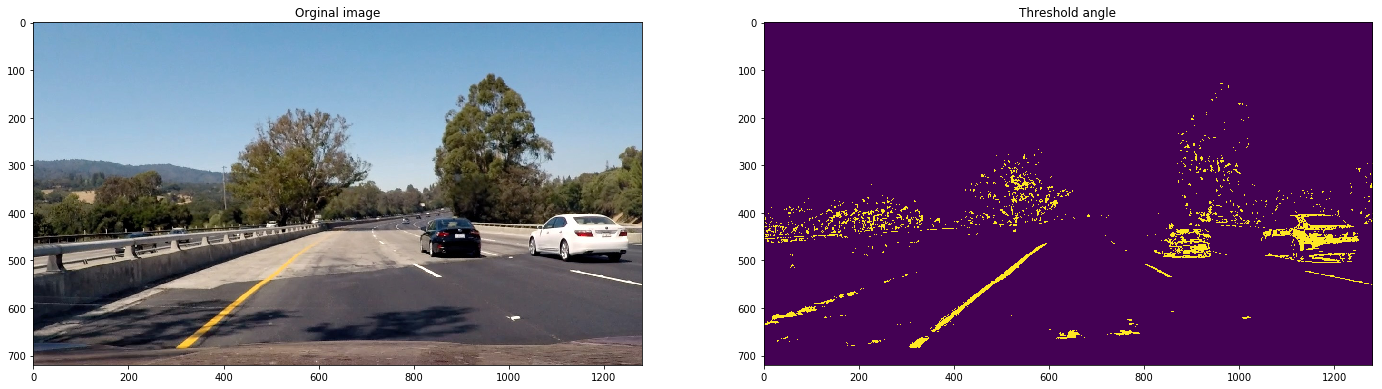

In [255]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def hls_saturation_thresh(img,thresh=(0,255)):
    """ apply saturation threshold on a image
    argugments:
    img -- input image
    thresh -- threshold for saturation channel in hls color space
    return -- a binary image with saturation within angle threshold 
    
    """
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]

    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

s_img = hls_saturation_thresh(img,thresh=(150,255))

plt.clf()

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(s_img)
ax2.set_title("Threshold angle")

plt.show()

### 4. Apply a perspective transform to rectify binary image ("birds-eye view") 

<IPython.core.display.Javascript object>


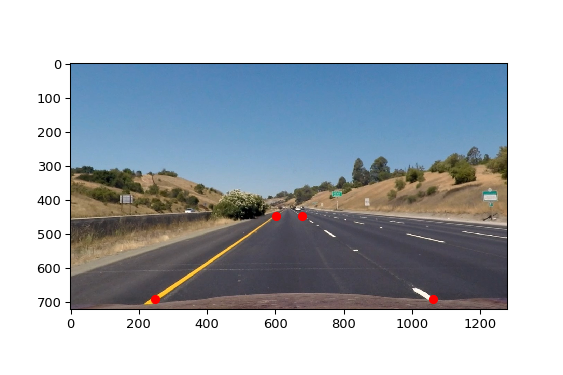

In [81]:
# get matrix of perspective transformation
%matplotlib notebook
# processing image with straight lines
straight_img = mpimg.imread('test_images/straight_lines1.jpg')
straight_img = cv2.undistort(straight_img,mtx,dist,None,mtx)

# source points from image
src = np.float32([[247,691],[601,447],[679,447],[1061,691]])
# target points rectangle
dst = np.float32([[300,720],[300,0],[900,0],[900,720]])

f = plt.figure()
plt.imshow(straight_img)
plt.plot(src[:,0],src[:,1],'ro')
_ = plt.show()


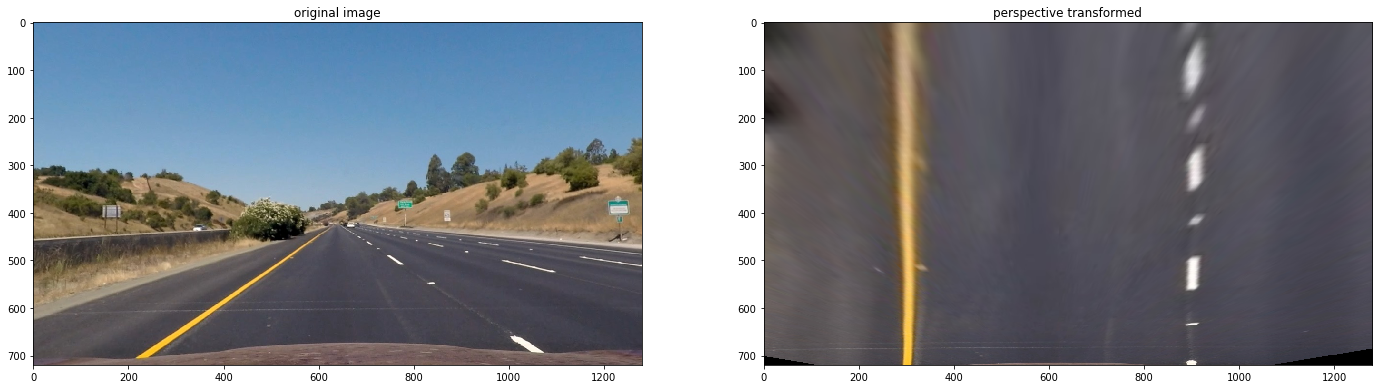

In [84]:
%matplotlib inline

M = cv2.getPerspectiveTransform(src,dst)

img_size = (straight_img.shape[1],straight_img.shape[0])
straight_p_img = cv2.warpPerspective(straight_img,M,img_size,flags=cv2.INTER_LINEAR)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.imshow(straight_img)
ax1.set_title("original image")

ax2.imshow(straight_p_img)
ax2.set_title("perspective transformed")

plt.show()

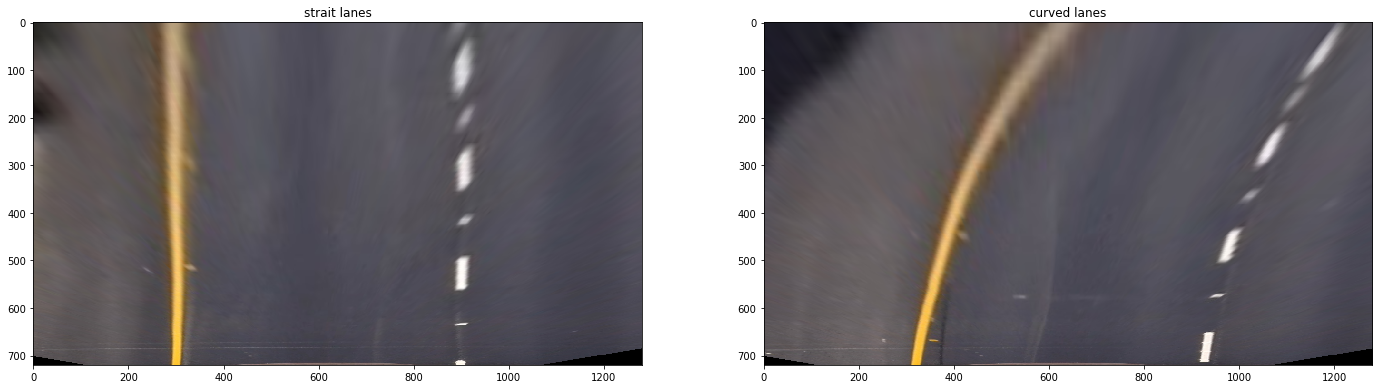

In [80]:
# add perspective transform on curved lanes
curv_img = mpimg.imread('test_images/test3.jpg')
curv_img = cv2.undistort(curv_img,mtx,dist,None,mtx)
curv_img = cv2.warpPerspective(curv_img,M,img_size,flags=cv2.INTER_LINEAR)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.imshow(straight_p_img)
ax1.set_title("strait lanes")
ax2.imshow(curv_img)
ax2.set_title("curved lanes")

plt.show()

### Here is the pipeline to get the binary image for further processing

In [268]:
img = mpimg.imread('test_images/test5.jpg')
img = cv2.undistort(img,mtx,dist,None,mtx)

img = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
img_c = img

abs_x = abs_thresh(img, orient='x',sobel_kernel=3,thresh=(10,100))
abs_y = abs_thresh(img, orient='y',sobel_kernel=3,thresh=(10,100))
mag_img = mag_thresh(img,sobel_kernel=3,thresh=(20,255))
dir_img = dir_thresh(img,sobel_kernel=15,thresh=(0.5,np.pi/2))
s_img = hls_saturation_thresh(img,thresh=(130,255))

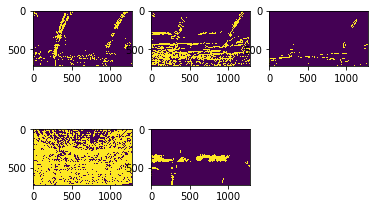

In [269]:
plt.subplot(2,3,1)
plt.imshow(abs_x)
plt.subplot(2,3,2)
plt.imshow(abs_y)
plt.subplot(2,3,3)
plt.imshow(mag_img)
plt.subplot(2,3,4)
plt.imshow(dir_img)
plt.subplot(2,3,5)
plt.imshow(s_img)
plt.show()

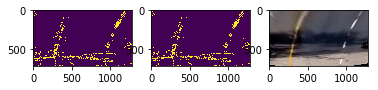

In [271]:
combined = np.zeros_like(abs_x)
combined[((abs_x == 1) & (abs_y == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1
com_cg = np.zeros_like(abs_x)
com_cg[(combined == 1) | ((s_img == 1) & (abs_x == 1))] =1

plt.subplot(1,3,1)
plt.imshow(com_cg)
plt.subplot(1,3,2)
plt.imshow(combined)
plt.subplot(1,3,3)
plt.imshow(img_c)
plt.show()

In [267]:
com_cg

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### 5. Detect lane pixels and fit to find the lane boundary.

In [105]:
mag_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)